# Fourier Transform Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import yfinance as yf
from datetime import datetime, timedelta

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# 1. What is "frequency" in time series?

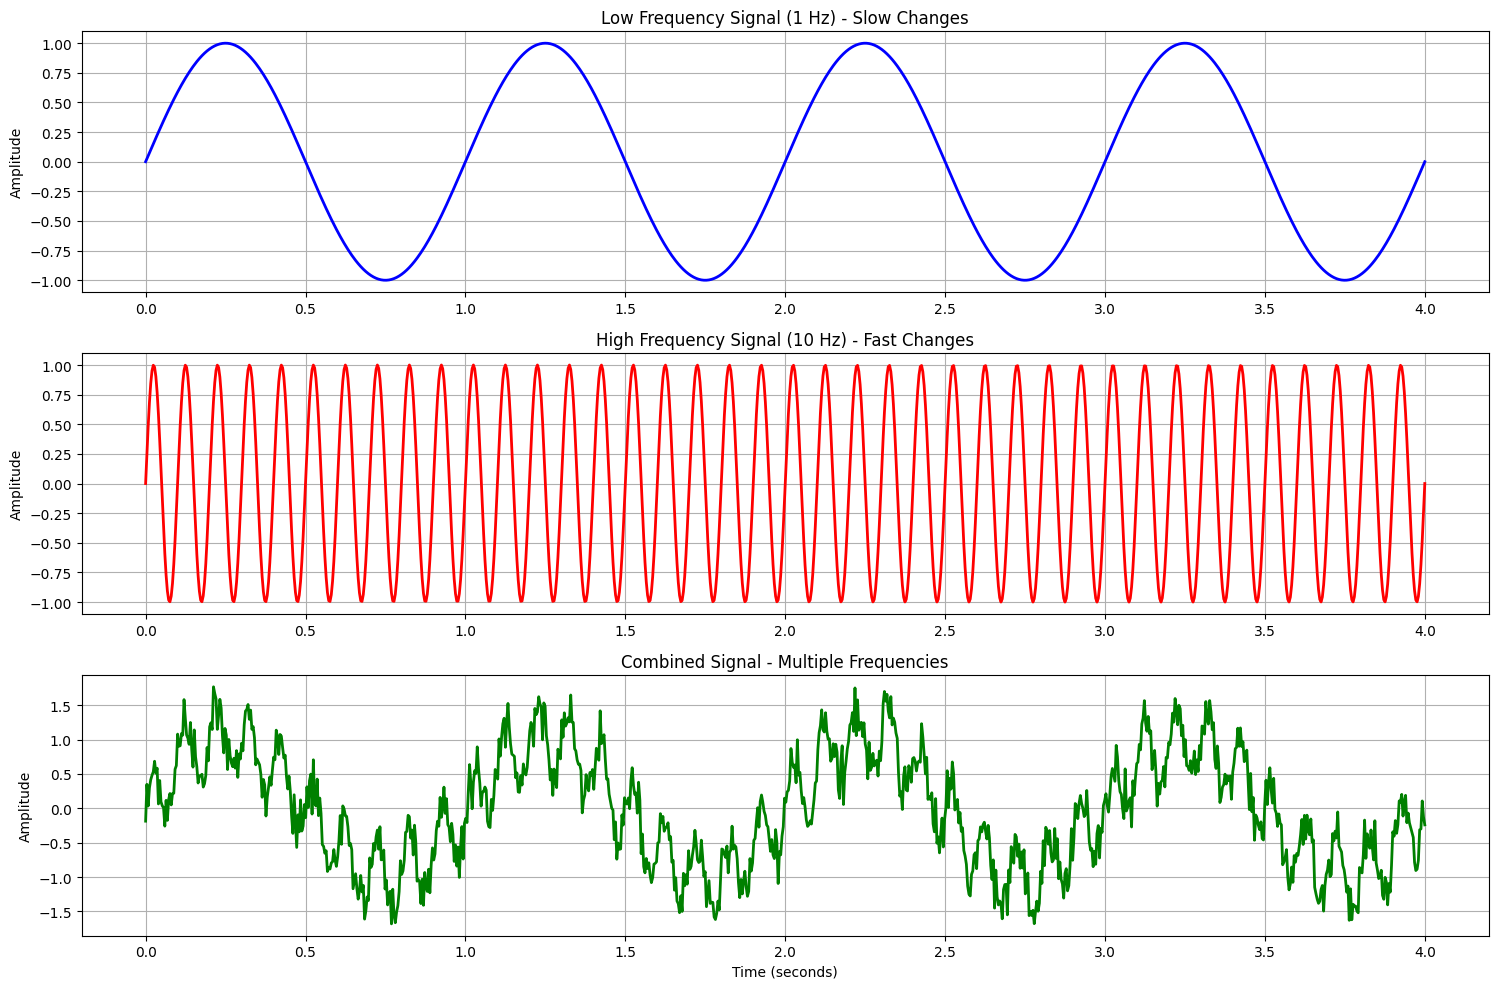

In [2]:
# Create simple synthetic signals first to build intuition
t = np.linspace(0, 4, 1000)  # 4 seconds of data, 1000 points

# Signal 1: Low frequency (slow oscillation)
low_freq = np.sin(2 * np.pi * 1 * t)  # 1 Hz = 1 cycle per second

# Signal 2: High frequency (fast oscillation) 
high_freq = np.sin(2 * np.pi * 10 * t)  # 10 Hz = 10 cycles per second

# Signal 3: Combined (this is more like real world data - multiple patterns)
combined = low_freq + 0.5 * high_freq + 0.2 * np.random.randn(len(t))

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(t, low_freq, 'b-', linewidth=2)
plt.title('Low Frequency Signal (1 Hz) - Slow Changes')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t, high_freq, 'r-', linewidth=2)
plt.title('High Frequency Signal (10 Hz) - Fast Changes')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t, combined, 'g-', linewidth=2)
plt.title('Combined Signal - Multiple Frequencies')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

Frequency - is really how often something repeast per unit of time. A "repetition rate".
1Hz == 1 cycle per second

Time - is what we usually see, the what happens when
- X axis: time
- Y axis: value

Frequency - what Fourier transform shows 
- X axis: frequency (cycles per time)
- Y axis: magnitude of frequency

Space - pattern space - different frequencies exist in different "regions" of the frequency spectrum.
- low frequencies - long term patterns, trends
- high frequencies - short term pattersn, noise

Frequencies are asking - what patterns repeat how often?
Time domain - what we usually see - what happens when?

# 2. Fourier Transform on Stock Data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


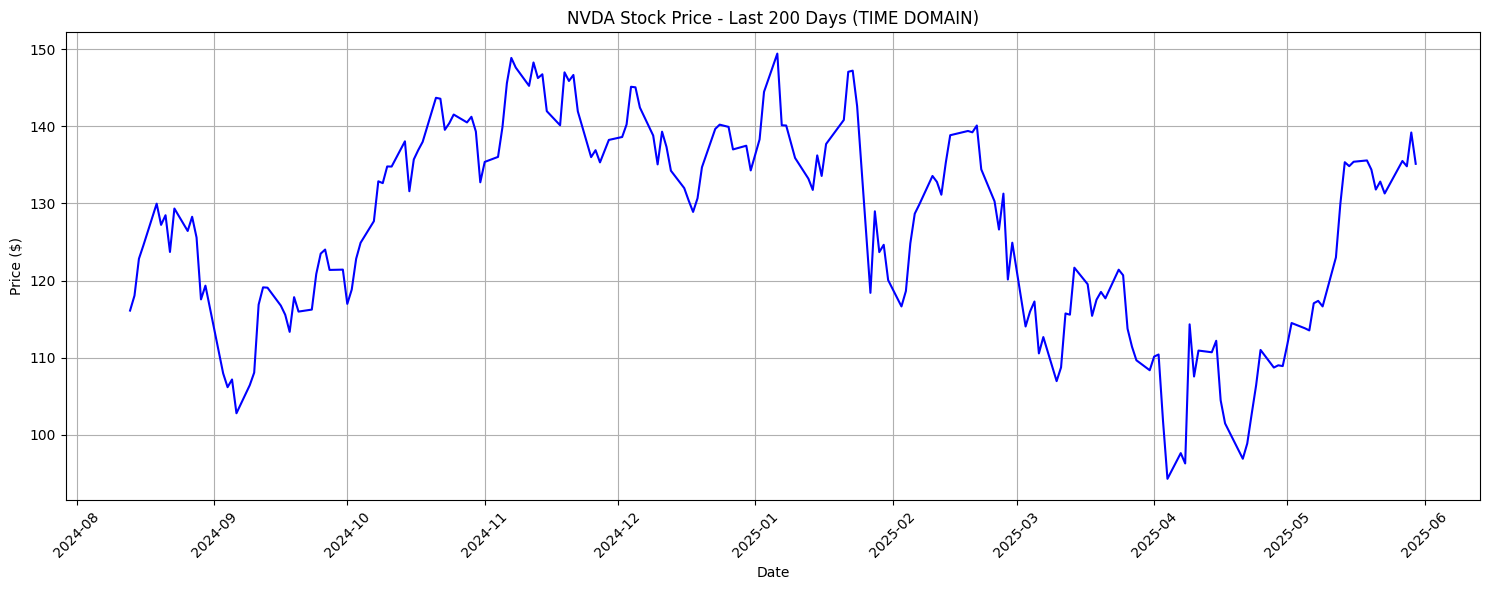

In [3]:
# Download Apple stock data (last 2 years)
ticker = "NVDA"
stock_data = yf.download(ticker, period="2y", interval="1d")
prices = stock_data['Close'].values
dates = stock_data.index

# Let's focus on the last 200 days for cleaner analysis
prices = prices[-200:]
dates = dates[-200:]

plt.figure(figsize=(15, 6))
plt.plot(dates, prices, 'b-', linewidth=1.5)
plt.title(f'{ticker} Stock Price - Last 200 Days (TIME DOMAIN)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

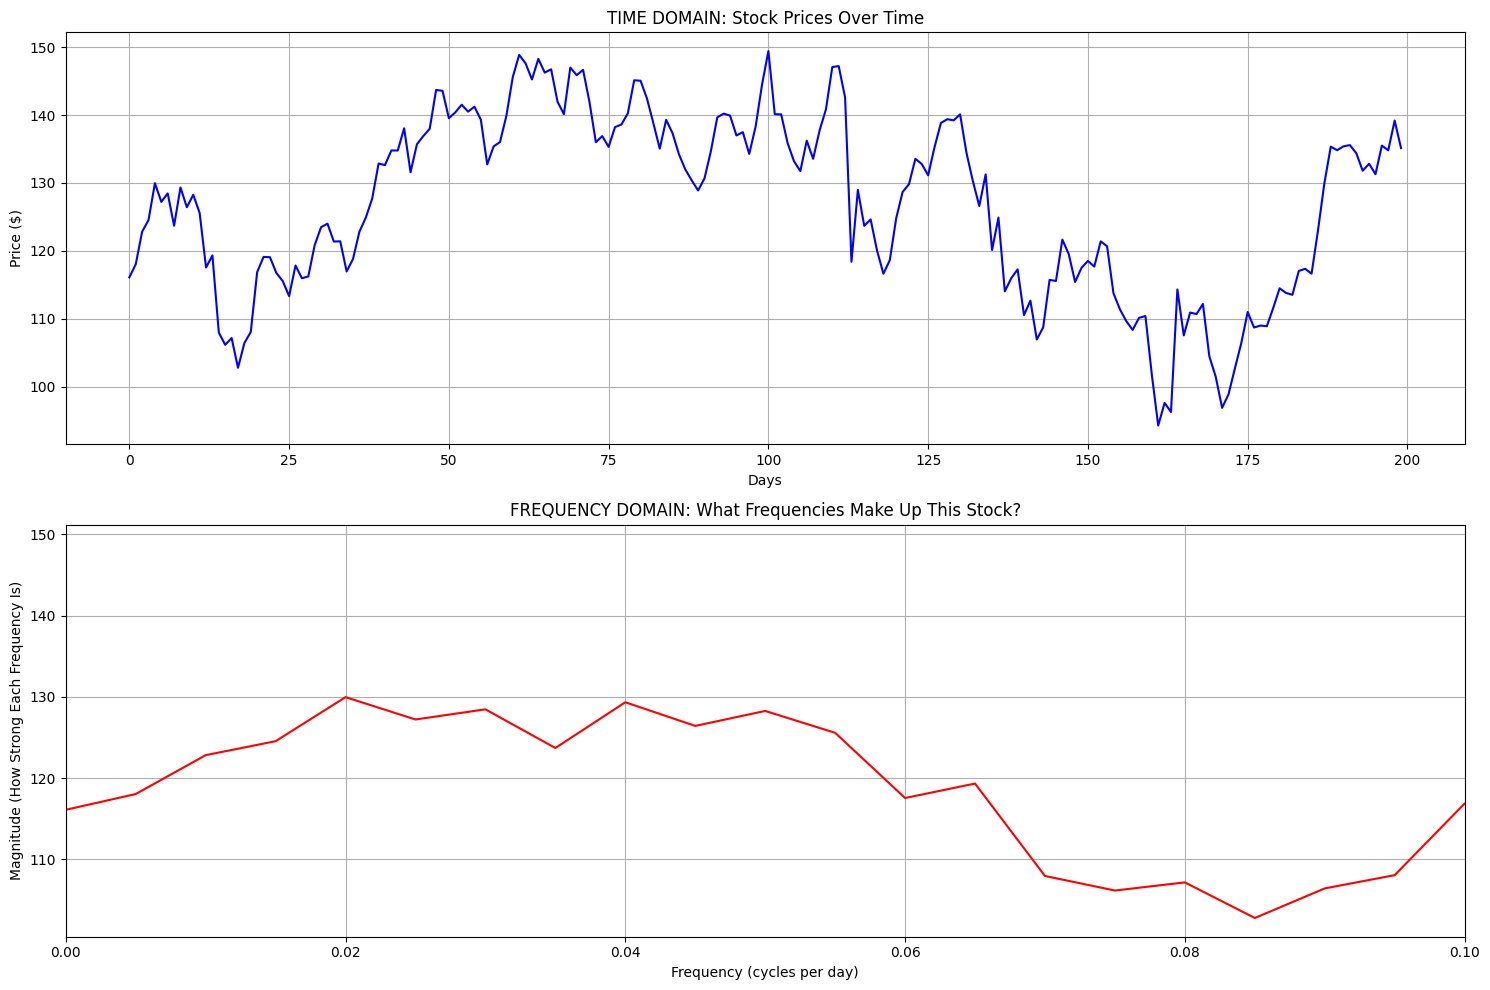

In [4]:
# Compute the Fourier Transform
fft_result = np.fft.fft(prices)
frequencies = np.fft.fftfreq(len(prices), d=1)  # d=1 means 1 day sampling

# Only take positive frequencies (the other half is mirror image)
n = len(prices) // 2
freqs_positive = frequencies[:n]
magnitude = np.abs(fft_result[:n])

plt.figure(figsize=(15, 10))

# Plot 1: Original time series
plt.subplot(2, 1, 1)
plt.plot(range(len(prices)), prices, 'b-', linewidth=1.5)
plt.title('TIME DOMAIN: Stock Prices Over Time')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.grid(True)

# Plot 2: Frequency domain
plt.subplot(2, 1, 2)
plt.plot(freqs_positive, magnitude, 'r-', linewidth=1.5)
plt.title('FREQUENCY DOMAIN: What Frequencies Make Up This Stock?')
plt.xlabel('Frequency (cycles per day)')
plt.ylabel('Magnitude (How Strong Each Frequency Is)')
plt.grid(True)
plt.xlim(0, 0.1)  # Focus on low frequencies where action happens

plt.tight_layout()
plt.show()

# 3. How to interpret the frequencies

🏆 DOMINANT FREQUENCIES FOUND:
  1. Frequency: 0.0200 cycles/day → Period: 50.0 days
  2. Frequency: 0.0300 cycles/day → Period: 33.3 days
  3. Frequency: 0.0400 cycles/day → Period: 25.0 days
  4. Frequency: 0.0500 cycles/day → Period: 20.0 days
  5. Frequency: 0.0650 cycles/day → Period: 15.4 days
  6. Frequency: 0.0800 cycles/day → Period: 12.5 days
  7. Frequency: 0.1050 cycles/day → Period: 9.5 days
  8. Frequency: 0.1300 cycles/day → Period: 7.7 days
  9. Frequency: 0.1550 cycles/day → Period: 6.5 days
  10. Frequency: 0.1650 cycles/day → Period: 6.1 days
  11. Frequency: 0.1950 cycles/day → Period: 5.1 days
  12. Frequency: 0.2050 cycles/day → Period: 4.9 days
  13. Frequency: 0.2150 cycles/day → Period: 4.7 days
  14. Frequency: 0.2400 cycles/day → Period: 4.2 days
  15. Frequency: 0.2600 cycles/day → Period: 3.8 days
  16. Frequency: 0.2700 cycles/day → Period: 3.7 days
  17. Frequency: 0.3050 cycles/day → Period: 3.3 days
  18. Frequency: 0.3200 cycles/day → Period: 3.1 days
 

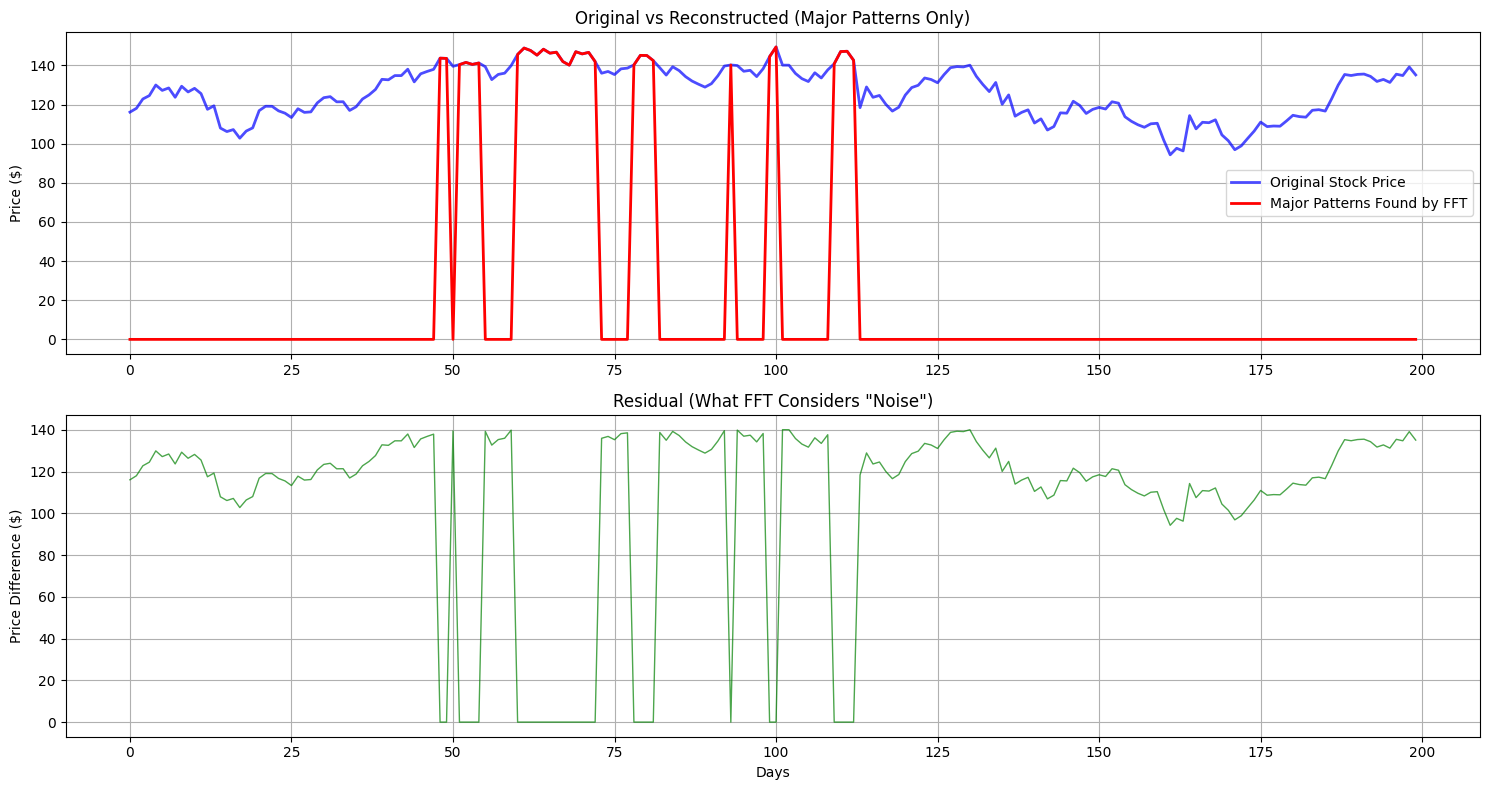

In [15]:
# Find the dominant frequencies
peak_indices = signal.find_peaks(magnitude.flatten(), height=np.max(magnitude)*0.1)[0]
dominant_freqs = freqs_positive[peak_indices]
dominant_magnitudes = magnitude[peak_indices]

print("🏆 DOMINANT FREQUENCIES FOUND:")
for i, (freq, mag) in enumerate(zip(dominant_freqs, dominant_magnitudes)):
    if freq > 0:  # Ignore zero frequency (DC component)
        period_days = 1 / freq if freq > 0 else float('inf')
        print(f"  {i+1}. Frequency: {freq:.4f} cycles/day → Period: {period_days:.1f} days")

# Let's reconstruct the signal using only the strongest frequencies
# This shows what patterns the Fourier transform found

# Keep only the strongest frequency components
threshold = np.percentile(magnitude_full, 85)  # Keep components above 5% of max
fft_filtered = fft_result.copy()

# FIXED: Apply threshold to magnitude, but preserve complex structure
magnitude_full = np.abs(fft_result)  # Full magnitude (not just positive half)
fft_filtered[magnitude_full < threshold] = 0

# Convert back to time domain
reconstructed = np.real(np.fft.ifft(fft_filtered))

print(f"Original signal range: {prices.min():.2f} to {prices.max():.2f}")
print(f"Reconstructed signal range: {reconstructed.min():.2f} to {reconstructed.max():.2f}")
print(f"Kept {np.sum(magnitude_full >= threshold)} out of {len(magnitude_full)} frequency components")

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(range(len(prices)), prices, 'b-', linewidth=2, label='Original Stock Price', alpha=0.7)
plt.plot(range(len(prices)), reconstructed, 'r-', linewidth=2, label='Major Patterns Found by FFT')
plt.title('Original vs Reconstructed (Major Patterns Only)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
residual = prices - reconstructed
plt.plot(range(len(prices)), residual, 'g-', linewidth=1, alpha=0.7)
plt.title('Residual (What FFT Considers "Noise")')
plt.xlabel('Days')
plt.ylabel('Price Difference ($)')
plt.grid(True)

plt.tight_layout()
plt.show()